In [1]:
import numpy as np
import random

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
# Function to parse the VRP dataset
# Replace 'your_dataset_path.vrp' with the actual path to your dataset file
file_path = 'benchmarks/B/B-n31-k5.vrp'  # Example: '/path/to/your/dataset/B-n31-k5.vrp'

def parse_vrp_dataset(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    coordinates = {}
    demands = {}
    capacity = 0
    section = None

    for line in lines:
        if "DIMENSION" in line:
            dimension = int(line.split(":")[1])
        elif "CAPACITY" in line:
            capacity = int(line.split(":")[1])
        elif "NODE_COORD_SECTION" in line:
            section = "coordinates"
            continue
        elif "DEMAND_SECTION" in line:
            section = "demands"
            continue
        elif "DEPOT_SECTION" in line:
            break  # Assuming we don't need depot specific info beyond this

        if section == "coordinates" and line.strip():
            parts = line.strip().split()
            coordinates[int(parts[0])] = (float(parts[1]), float(parts[2]))
        elif section == "demands" and line.strip():
            parts = line.strip().split()
            demands[int(parts[0])] = int(parts[1])

    return coordinates, demands, capacity

coordinates, demands, vehicle_capacity = parse_vrp_dataset(file_path)


# Now, you can use 'coordinates', 'demands', and 'vehicle_capacity' in your ACO implementation
# Example: calculating the distance matrix, initializing ants, etc., as shown in the previous code block.

# Your ACO implementation code here...


In [5]:
# Helper function to calculate Euclidean distance
def euclidean_distance(coord1, coord2):
    return np.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

In [6]:
# Function to calculate distance matrix between all locations
def calculate_distance_matrix(coordinates):
    n = len(coordinates)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            distances[i, j] = euclidean_distance(coordinates[i+1], coordinates[j+1])
    return distances

In [7]:
# ACO parameters
num_ants = 10
num_iterations = 100
alpha = 1.0  # Influence of pheromone
beta = 5.0  # Influence of heuristic information (distance)
evaporation_rate = 0.5
pheromone_deposit = 1.0
capacity = 100  # Vehicle capacity from the dataset

# Initialization
distances = calculate_distance_matrix(coordinates)
pheromones = np.ones(distances.shape) / len(coordinates)
demand_list = np.array(list(demands.values()))

In [8]:
# Function to select the next node based on ACO transition rule
def select_next_node(current_node, taboo_list, demands, vehicle_capacity):
    probabilities = np.zeros(len(distances))
    for i in range(len(distances)):
        if i not in taboo_list and demands[i] <= vehicle_capacity:
            try:
                probabilities[i] = pheromones[current_node][i]**alpha * (1.0 / distances[current_node][i])**beta
            except ZeroDivisionError:
                pass
    probabilities /= probabilities.sum()
    return np.random.choice(np.arange(len(distances)), p=probabilities)

In [9]:
def aco_main_loop(num_ants, num_iterations, distances, demands, vehicle_capacity, alpha, beta, evaporation_rate, pheromone_deposit,pheromones):
    best_route = None
    best_route_length = float('inf')
    
    for iteration in range(num_iterations):
        routes = []
        route_lengths = []
        
        for ant in range(num_ants):
            # Initialize ant
            route = [0]  # Starting at the depot
            remaining_capacity = vehicle_capacity
            remaining_nodes = set(range(1, len(distances)))  # Excluding the depot initially
            
            while remaining_nodes:
                current_node = route[-1]
                if remaining_capacity < min([demands[n] for n in remaining_nodes]):
                    # Return to depot if the remaining capacity is less than the demands of all remaining nodes
                    route.append(0)
                    remaining_capacity = vehicle_capacity
                    continue
                
                probabilities = []
                for next_node in remaining_nodes:
                    if demands[next_node] <= remaining_capacity:
                        tau = pheromones[current_node][next_node] ** alpha
                        eta = (1.0 / distances[current_node][next_node]) ** beta
                        probabilities.append(tau * eta)
                    else:
                        probabilities.append(0)
                
                probabilities = np.array(probabilities) / sum(probabilities)
                next_node = random.choices(list(remaining_nodes), weights=probabilities, k=1)[0]
                
                route.append(next_node)
                remaining_nodes.remove(next_node)
                remaining_capacity -= demands[next_node]
                # Return to depot to offload if needed
            if remaining_capacity == 0:
                    route.append(0)
                    remaining_capacity = vehicle_capacity
                    # Complete the route by returning to the depot
            if route[-1] != 0:
                route.append(0)
                # Calculate the length of the route
            route_length = sum(distances[route[i]][route[i+1]] for i in range(len(route)-1))
            routes.append(route)
            route_lengths.append(route_length)
            # Update best route
        min_route_length = min(route_lengths)
        if min_route_length < best_route_length:
            best_route_length = min_route_length
            best_route = routes[route_lengths.index(min_route_length)]
            # Update pheromones
        pheromones *= (1 - evaporation_rate)  # Evaporation
        for route, length in zip(routes, route_lengths):
            deposit_amount = pheromone_deposit / length
            for i in range(len(route)-1):
                pheromones[route[i]][route[i+1]] += deposit_amount
        
        # Optionally, add extra pheromone on the global best route
        # for i in range(len(best_route)-1):
        #     pheromones[best_route[i]][best_route[i+1]] += extra_deposit
        
    return best_route, best_route_length


In [10]:
# You would call this function with the ACO parameters and the parsed data from your VRP dataset
best_route, best_route_length = aco_main_loop(
    num_ants=num_ants, 
    num_iterations=num_iterations, 
    distances=distances, 
    demands=demand_list, 
    vehicle_capacity=capacity, 
    alpha=alpha, 
    beta=beta, 
    evaporation_rate=evaporation_rate, 
    pheromone_deposit=pheromone_deposit,
    pheromones=pheromones  # Include this line to pass the pheromone matrix
)

/var/folders/rq/cmshwwsj103bctlx4qzgfl940000gn/T/ipykernel_84992/1298867322.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  eta = (1.0 / distances[current_node][next_node]) ** beta
/var/folders/rq/cmshwwsj103bctlx4qzgfl940000gn/T/ipykernel_84992/1298867322.py:32: RuntimeWarning: invalid value encountered in divide
  probabilities = np.array(probabilities) / sum(probabilities)


In [11]:
print("Best Route:", best_route)
print("Best Route Length:", best_route_length)

Best Route: [0, 16, 18, 25, 5, 21, 29, 17, 30, 0, 20, 10, 27, 2, 14, 11, 15, 24, 19, 0, 4, 22, 13, 9, 6, 3, 8, 0, 26, 28, 12, 23, 7, 0, 1, 0]
Best Route Length: 743.641586958152


In [12]:
import os
import glob

# Assuming 'parse_vrp_dataset' and 'aco_main_loop' are defined functions
# from previous discussions.

# Directory where your VRP files are stored
dataset_directory = '/Users/rishithareddyavuku/Downloads/VehicleRoutingProblem-master/benchmarks/B'

# Find all VRP files
vrp_files = glob.glob(os.path.join(dataset_directory, '*.vrp'))

# Dictionary to store the best route length for each file
best_route_lengths = {}

for vrp_file in vrp_files:
    # Parse the VRP file
    coordinates, demands, vehicle_capacity = parse_vrp_dataset(vrp_file)
    
    # Initialize distances and pheromones, assuming you have functions or code for this
    distances = calculate_distance_matrix(coordinates)
    pheromones = np.ones(distances.shape) / len(coordinates)
    
    # Solve the VRP instance using ACO
    best_route, best_route_length = aco_main_loop(
        num_ants=10,  # You may adjust these parameters as needed
        num_iterations=100,
        distances=distances,
        demands=np.array(list(demands.values())),
        vehicle_capacity=vehicle_capacity,
        alpha=1.0,
        beta=5.0,
        evaporation_rate=0.5,
        pheromone_deposit=1.0,
        pheromones=pheromones
    )
    
    # Store or print the result
    best_route_lengths[os.path.basename(vrp_file)] = best_route_length

# Print all results
for vrp_file, length in best_route_lengths.items():
    print(f"{vrp_file}: Best Route Length = {length}")


/var/folders/rq/cmshwwsj103bctlx4qzgfl940000gn/T/ipykernel_84992/1298867322.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  eta = (1.0 / distances[current_node][next_node]) ** beta
/var/folders/rq/cmshwwsj103bctlx4qzgfl940000gn/T/ipykernel_84992/1298867322.py:32: RuntimeWarning: invalid value encountered in divide
  probabilities = np.array(probabilities) / sum(probabilities)


B-n34-k5.vrp: Best Route Length = 730.5233716620145
B-n45-k5.vrp: Best Route Length = 973.9182450837992
B-n64-k9.vrp: Best Route Length = 1179.8257424179471
B-n68-k9.vrp: Best Route Length = 1596.3605454387548
B-n38-k6.vrp: Best Route Length = 1004.6227735625301
B-n45-k6.vrp: Best Route Length = 889.0800595015836
B-n57-k7.vrp: Best Route Length = 1649.9823940084023
B-n67-k10.vrp: Best Route Length = 1376.215435511665
B-n66-k9.vrp: Best Route Length = 1537.9933216812756
B-n50-k8.vrp: Best Route Length = 1475.3606398633813
B-n51-k7.vrp: Best Route Length = 1155.3203756476216
B-n43-k6.vrp: Best Route Length = 890.9682000394735
B-n41-k6.vrp: Best Route Length = 890.4661941463672
B-n44-k7.vrp: Best Route Length = 1122.5834257226527
B-n56-k7.vrp: Best Route Length = 1001.2388779917691
B-n35-k5.vrp: Best Route Length = 1141.2508705480243
B-n78-k10.vrp: Best Route Length = 1470.498161565631
B-n39-k5.vrp: Best Route Length = 816.9617824355295
B-n50-k7.vrp: Best Route Length = 966.034519762857
B

In [22]:
import os
import glob
import pandas as pd
import numpy as np

# Adjusting the parse_vrp_dataset function to also return the optimal cost
def parse_vrp_dataset_with_optimal_cost(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    coordinates = {}
    demands = {}
    capacity = 0
    optimal_cost = None  # Initialize optimal cost
    section = None

    for line in lines:
        if "DIMENSION" in line:
            dimension = int(line.split(":")[1])
        elif "CAPACITY" in line:
            capacity = int(line.split(":")[1])
        # Inside your parse_vrp_dataset_with_optimal_cost function
        elif "COMMENT" in line and "Optimal value:" in line:
    # Extracting the optimal cost, ensuring we remove non-numeric characters like parentheses
            optimal_cost_str = line.split("Optimal value:")[-1].split()[0]  # This gets the value as a string
            optimal_cost = float(''.join(filter(str.isdigit, optimal_cost_str)))  # Converts to float, removing non-digits

        elif "NODE_COORD_SECTION" in line:
            section = "coordinates"
            continue
        elif "DEMAND_SECTION" in line:
            section = "demands"
            continue
        elif "DEPOT_SECTION" in line:
            break

        if section == "coordinates" and line.strip():
            parts = line.strip().split()
            coordinates[int(parts[0])] = (float(parts[1]), float(parts[2]))
        elif section == "demands" and line.strip():
            parts = line.strip().split()
            demands[int(parts[0])] = int(parts[1])

    return coordinates, demands, capacity, optimal_cost

# Directory where your VRP files are stored
dataset_directory = '/Users/rishithareddyavuku/Downloads/VehicleRoutingProblem-master/benchmarks/B'

# Find all VRP files
vrp_files = glob.glob(os.path.join(dataset_directory, '*.vrp'))

# Initialize a DataFrame to store results
results_df = pd.DataFrame(columns=['File Name', 'Optimal Cost', 'Error Rate (%)'])

for vrp_file in vrp_files:
    # Parse the VRP file including optimal cost
    coordinates, demands, vehicle_capacity, optimal_cost = parse_vrp_dataset_with_optimal_cost(vrp_file)
    
    # Your ACO algorithm here to find best_route and best_route_length...
    
    # Calculate error rate
    error_rate = ((best_route_length - optimal_cost) / optimal_cost) * 100 if optimal_cost else None
    
    # Append results to the DataFrame
    results_df = results_df.append({
        'File Name': os.path.basename(vrp_file),
        'Optimal Cost': optimal_cost,
        'Error Rate (%)': error_rate
    }, ignore_index=True)
    
# Display the results in a tabular format
print(results_df)


        File Name  Optimal Cost  Error Rate (%)
0    B-n34-k5.vrp         788.0       -7.395604
1    B-n45-k5.vrp         751.0       -2.833204
2    B-n64-k9.vrp         861.0      -15.247080
3    B-n68-k9.vrp        1272.0      -42.631868
4    B-n38-k6.vrp         805.0       -9.351225
5    B-n45-k6.vrp         678.0        7.628708
6    B-n57-k7.vrp        1153.0      -36.710959
7   B-n67-k10.vrp        1032.0      -29.290442
8    B-n66-k9.vrp        1316.0      -44.549952
9    B-n50-k8.vrp        1312.0      -44.380897
10   B-n51-k7.vrp        1032.0      -29.290442
11   B-n43-k6.vrp         742.0       -1.654631
12   B-n41-k6.vrp         829.0      -11.975556
13   B-n44-k7.vrp         909.0      -19.722482
14   B-n56-k7.vrp         707.0        3.213952
15   B-n35-k5.vrp         955.0      -23.589253
16  B-n78-k10.vrp        1221.0      -40.235656
17   B-n39-k5.vrp         549.0       32.918513
18   B-n50-k7.vrp         741.0       -1.521911
19   B-n52-k7.vrp         747.0       -2

/var/folders/rq/cmshwwsj103bctlx4qzgfl940000gn/T/ipykernel_84992/3347354608.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/rq/cmshwwsj103bctlx4qzgfl940000gn/T/ipykernel_84992/3347354608.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/rq/cmshwwsj103bctlx4qzgfl940000gn/T/ipykernel_84992/3347354608.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/rq/cmshwwsj103bctlx4qzgfl940000gn/T/ipykernel_84992/3347354608.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.appen

In [23]:
import os
import glob
import pandas as pd
import numpy as np

# Assume 'parse_vrp_dataset_with_optimal_cost' and 'aco_main_loop' are defined as shown above.

# Initialize a DataFrame to store results, now including 'Best Route Length'
results_df = pd.DataFrame(columns=['File Name', 'Best Route Length', 'Optimal Cost', 'Error Rate (%)'])

for vrp_file in vrp_files:
    # Parse the VRP file including optimal cost
    coordinates, demands, vehicle_capacity, optimal_cost = parse_vrp_dataset_with_optimal_cost(vrp_file)
    
    # Calculate distances and initialize pheromones
    distances = calculate_distance_matrix(coordinates)
    pheromones = np.ones(distances.shape) / len(coordinates)
    
    # Solve the VRP instance using ACO to find best_route and best_route_length
    best_route, best_route_length = aco_main_loop(
        num_ants=10,
        num_iterations=100,
        distances=distances,
        demands=np.array(list(demands.values())),
        vehicle_capacity=vehicle_capacity,
        alpha=1.0,
        beta=5.0,
        evaporation_rate=0.5,
        pheromone_deposit=1.0,
        pheromones=pheromones
    )
    
    # Calculate error rate if optimal cost is available
    error_rate = ((best_route_length - optimal_cost) / optimal_cost) * 100 if optimal_cost is not None else None
    
    # Append results to the DataFrame
    results_df = results_df.append({
        'File Name': os.path.basename(vrp_file),
        'Best Route Length': best_route_length,
        'Optimal Cost': optimal_cost,
        'Error Rate (%)': error_rate
    }, ignore_index=True)
    
# Display the results in a tabular format
print(results_df)


/var/folders/rq/cmshwwsj103bctlx4qzgfl940000gn/T/ipykernel_84992/1298867322.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  eta = (1.0 / distances[current_node][next_node]) ** beta
/var/folders/rq/cmshwwsj103bctlx4qzgfl940000gn/T/ipykernel_84992/1298867322.py:32: RuntimeWarning: invalid value encountered in divide
  probabilities = np.array(probabilities) / sum(probabilities)
/var/folders/rq/cmshwwsj103bctlx4qzgfl940000gn/T/ipykernel_84992/900686762.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/rq/cmshwwsj103bctlx4qzgfl940000gn/T/ipykernel_84992/900686762.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/rq/cmshwwsj103bctlx4qzgfl940000gn/T/ipykernel_84992/1298867322.py:27: RuntimeWarning: d

/var/folders/rq/cmshwwsj103bctlx4qzgfl940000gn/T/ipykernel_84992/900686762.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/rq/cmshwwsj103bctlx4qzgfl940000gn/T/ipykernel_84992/1298867322.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  eta = (1.0 / distances[current_node][next_node]) ** beta
/var/folders/rq/cmshwwsj103bctlx4qzgfl940000gn/T/ipykernel_84992/1298867322.py:32: RuntimeWarning: invalid value encountered in divide
  probabilities = np.array(probabilities) / sum(probabilities)
/var/folders/rq/cmshwwsj103bctlx4qzgfl940000gn/T/ipykernel_84992/900686762.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/rq/cmshwwsj103bctlx4qzgfl940000gn/T/ipykernel_84992/1298867322.py:27: RuntimeWarning: d

        File Name  Best Route Length  Optimal Cost  Error Rate (%)
0    B-n34-k5.vrp         777.024990         788.0       -1.392768
1    B-n45-k5.vrp         964.085375         751.0       28.373552
2    B-n64-k9.vrp        1187.832165         861.0       37.959601
3    B-n68-k9.vrp        1511.258890        1272.0       18.809661
4    B-n38-k6.vrp        1009.209995         805.0       25.367701
5    B-n45-k6.vrp         852.405169         678.0       25.723476
6    B-n57-k7.vrp        1500.671715        1153.0       30.153661
7   B-n67-k10.vrp        1353.725046        1032.0       31.174908
8    B-n66-k9.vrp        1499.076865        1316.0       13.911616
9    B-n50-k8.vrp        1438.135628        1312.0        9.613996
10   B-n51-k7.vrp        1210.224146        1032.0       17.269782
11   B-n43-k6.vrp         884.755724         742.0       19.239316
12   B-n41-k6.vrp         967.068151         829.0       16.654783
13   B-n44-k7.vrp        1141.608139         909.0       25.58

/var/folders/rq/cmshwwsj103bctlx4qzgfl940000gn/T/ipykernel_84992/900686762.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


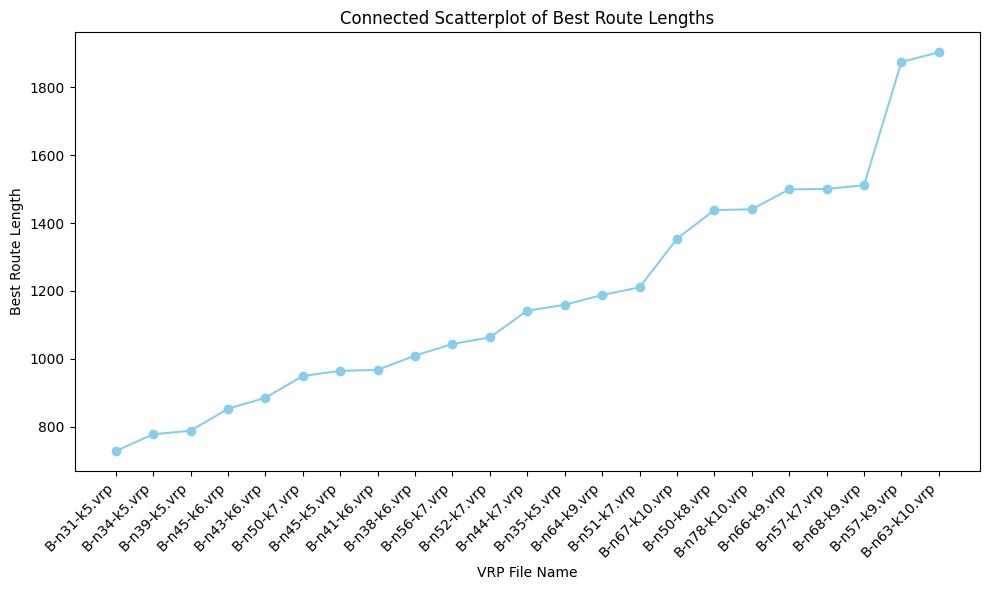

In [25]:
import matplotlib.pyplot as plt

# Optionally, sort the DataFrame by some column if the order of points matters
# results_df.sort_values('SomeColumn', inplace=True)

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(results_df['File Name'], results_df['Best Route Length'], '-o', color='skyblue')  # '-o' creates lines and points

plt.xlabel('VRP File Name')
plt.ylabel('Best Route Length')
plt.xticks(rotation=45, ha="right")  # Rotate file names for better readability
plt.title('Connected Scatterplot of Best Route Lengths')
plt.tight_layout()  # Adjust layout

plt.show()


In [ ]:
# Create a new DataFrame for the table
table_df = pd.DataFrame({
    'VRP Instance': results_df['File Name'],
    'ACO Length': results_df['Best Route Length'],
    'ABC Cost': b_stat['ABC_cost']
})


In [ ]:
def style_table(df):
    return df.style.format({
            'ACO Length': '{:.2f}',
            'ABC Cost': '{:.2f}'
        })\
        .hide_index()\
        .bar(subset=['ACO Length', 'ABC Cost'], color='#d65f5f')\
        .set_table_styles([{
            'selector': 'th',
            'props': [('background-color', '#4c72b0'), ('color', 'white'), ('text-align', 'center')]
        }, {
            'selector': 'td',
            'props': [('text-align', 'center')]
        }])\
        .applymap(lambda x: 'font-weight: bold;', subset=['ACO Length', 'ABC Cost'])\
        .set_properties(**{'border': '1.5px solid black', 'border-collapse': 'collapse'})

styled_table = style_table(table_df)
styled_table

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


# Assuming results_df, info_dct, and other variables are defined

# Plotting the first subplot
plt.figure(figsize=(15, 10))

# Subplot 1: Connected Scatterplot of Best Route Lengths
plt.subplot(2, 2, 1)
results_df['File Name'] = results_df['File Name'].astype(str)
plt.plot(results_df['File Name'], results_df['Best Route Length'], '-o', color='skyblue')
plt.xlabel('VRP File Name')
plt.ylabel('Best Route Length')
plt.xticks(rotation=45, ha="right")
plt.title('Connected Scatterplot of Best Route Lengths')

# Subplot 2: ABC Costs Across Benchmarks
plt.subplot(2, 2, 2)
b_stat = pd.DataFrame.from_dict(info_dct)
plt.plot(b_stat['benchmark'], b_stat['ABC_cost'], '-o', label='ABC Cost', color='skyblue')
plt.xlabel('Benchmark')
plt.ylabel('Cost')
plt.xticks(rotation=45, ha="right")
plt.title('ABC Costs Across Benchmarks')
plt.legend()

# Subplot 3: Lowest Route Distance by Dataset
plt.subplot(2, 1, 2)
dataset_indices = range(len(results_df))
lowest_distances = results_df['Lowest Route Distance']
plt.plot(dataset_indices, lowest_distances, '-o', color='blue', label='Lowest Distance', alpha=0.75)
plt.scatter(dataset_indices, lowest_distances, color='red', alpha=0.75)
plt.title('Lowest Route Distance by Dataset')
plt.xlabel('Dataset Index')
plt.ylabel('Lowest Route Distance')
plt.xticks(dataset_indices, results_df['Dataset'], rotation='vertical')
plt.legend()

plt.tight_layout()  # Adjust layout
plt.show()
